In [9]:
pip install Pillow


In [10]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import tensorflow as tf
import xml.etree.ElementTree as ET
from PIL import Image
import io

def create_tf_example(annotation_path, image_path, class_names, target_size=(224, 224)):
    with tf.io.gfile.GFile(annotation_path, 'r') as fid:
        xml_str = fid.read()
    xml = ET.fromstring(xml_str)
    filename = xml.find('filename').text
    width = int(xml.find('size/width').text)
    height = int(xml.find('size/height').text)
    
    xmins, xmaxs, ymins, ymaxs = [], [], [], []
    classes_text, classes = [], []
    
    for obj in xml.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_names:
            continue
        classes_text.append(class_name.encode('utf8'))
        classes.append(class_names.index(class_name) + 1)  # class indices are 1-based
        bbox = obj.find('bndbox')
        xmins.append(float(bbox.find('xmin').text) / width)
        xmaxs.append(float(bbox.find('xmax').text) / width)
        ymins.append(float(bbox.find('ymin').text) / height)
        ymaxs.append(float(bbox.find('ymax').text) / height)
    
    # Resize and convert to RGB
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    with io.BytesIO() as output:
        image.save(output, format="JPEG")
        encoded_image_data = output.getvalue()
    
    feature = {
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[target_size[0]])),
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[target_size[1]])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image_data])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'jpg'])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=[0])),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=[0])),
        'image/object/view': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'Unspecified'])),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))



def convert_to_tfrecord(dataset_dir, output_dir, class_names):
    for subset in ['train', 'validation']:
        input_images_dir = os.path.join(dataset_dir, subset, 'images')
        input_annotations_dir = os.path.join(dataset_dir, subset, 'annotations')
        
        # Create the output directory for the subset if it does not exist
        subset_output_dir = os.path.join(output_dir, subset)
        os.makedirs(subset_output_dir, exist_ok=True)
        
        for class_name in class_names:
            class_dir = os.path.join(input_images_dir, class_name)
            for image_filename in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_filename)
                annotation_path = os.path.join(input_annotations_dir, image_filename.replace('.jpg', '.xml'))
                if not os.path.exists(annotation_path):
                    continue
                tf_example = create_tf_example(annotation_path, image_path, class_names)
                
                # Create a separate TFRecord file for each image
                output_path = os.path.join(subset_output_dir, f'{image_filename.replace(".jpg", "")}.tfrecord')
                with tf.io.TFRecordWriter(output_path) as writer:
                    writer.write(tf_example.SerializeToString())



dataset_dir = 'D:/content/NEU-DET'
output_dir = 'D:/content/tensorflow/training_demo/annotations'
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']

convert_to_tfrecord(dataset_dir, output_dir, class_names)


In [12]:
import tensorflow as tf
import os

def parse_tfrecord(tfrecord):
    features = {
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

    return tf.io.parse_single_example(tfrecord, features)

def inspect_tfrecords(tfrecord_dir, num_records=5):
    tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(tfrecord_dir) if f.endswith('.tfrecord')]
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    for i, raw_record in enumerate(dataset.take(num_records)):
        example = parse_tfrecord(raw_record)
        width = example['image/width'].numpy()
        height = example['image/height'].numpy()
        filename = example['image/filename'].numpy().decode('utf-8')
        num_objects = len(example['image/object/class/label'].values.numpy())

        print(f"Record {i+1}:")
        print(f"  Filename: {filename}")
        print(f"  Image Shape: {width}x{height}")
        print(f"  Number of Objects: {num_objects}")
        print('-' * 30)

# Example usage
tfrecord_dir = 'D:/content/tensorflow/training_demo/annotations/train'  # Adjust the path to your TFRecord directory
inspect_tfrecords(tfrecord_dir, num_records=5)


Record 1:
  Filename: crazing_1.jpg
  Image Shape: 224x224
  Number of Objects: 1
------------------------------
Record 2:
  Filename: crazing_10.jpg
  Image Shape: 224x224
  Number of Objects: 2
------------------------------
Record 3:
  Filename: crazing_100.jpg
  Image Shape: 224x224
  Number of Objects: 4
------------------------------
Record 4:
  Filename: crazing_101.jpg
  Image Shape: 224x224
  Number of Objects: 1
------------------------------
Record 5:
  Filename: crazing_102.jpg
  Image Shape: 224x224
  Number of Objects: 2
------------------------------


In [13]:
import tensorflow as tf

def parse_tfrecord(tfrecord):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_example = tf.io.parse_single_example(tfrecord, feature_description)
    image = tf.io.decode_jpeg(parsed_example['image/encoded'])
    height = parsed_example['image/height']
    width = parsed_example['image/width']
    return image, height, width

def check_tensor_shape(tfrecord_file):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    for raw_record in raw_dataset.take(1):
        image, height, width = parse_tfrecord(raw_record)
        print(f"Image shape: {image.shape}")
        print(f"Image height: {height}")
        print(f"Image width: {width}")

# Replace 'your_tfrecord_file.tfrecord' with the path to one of your TFRecord files
tfrecord_file = 'D:/content/tensorflow/training_demo/annotations/train/crazing_1.tfrecord'
check_tensor_shape(tfrecord_file)


Image shape: (224, 224, 3)
Image height: 224
Image width: 224


In [14]:
import tensorflow as tf

# Define your feature description
feature_description = {
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/source_id': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),  # Corrected
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    'image/object/difficult': tf.io.VarLenFeature(tf.int64),
    'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    'image/object/view': tf.io.VarLenFeature(tf.string)
}

# Path to your TFRecord file
tfrecord_file = 'D:/content/tensorflow/training_demo/annotations/train/crazing_11.tfrecord'

# Create a TFRecordDataset
dataset = tf.data.TFRecordDataset(tfrecord_file)

# Read and parse a single example
for raw_record in dataset.take(1):
    example = tf.io.parse_single_example(raw_record, feature_description)

    # Print the shapes of the features
    for key, value in example.items():
        if isinstance(value, tf.SparseTensor):
            # For VarLenFeatures, convert to dense tensor first
            value = tf.sparse.to_dense(value)
        print(f"{key}: {value.shape}")


image/object/bbox/xmax: (3,)
image/object/bbox/xmin: (3,)
image/object/bbox/ymax: (3,)
image/object/bbox/ymin: (3,)
image/object/class/label: (3,)
image/object/class/text: (3,)
image/object/difficult: (1,)
image/object/truncated: (1,)
image/object/view: (1,)
image/encoded: ()
image/filename: ()
image/format: ()
image/height: ()
image/source_id: ()
image/width: ()


In [15]:
# Read and parse a single example
for raw_record in dataset.take(1):
    example = tf.io.parse_single_example(raw_record, feature_description)
    image_encoded = example['image/encoded'].numpy()  # Get the bytes of the encoded image
    image = tf.io.decode_jpeg(image_encoded)  # Decode the image
    print("Decoded image shape:", image.shape)


Decoded image shape: (224, 224, 3)


In [16]:
def parse_tfrecord(example_proto):
    feature_description = {
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/difficult': tf.io.VarLenFeature(tf.int64),
        'image/object/truncated': tf.io.VarLenFeature(tf.int64),
        'image/object/view': tf.io.VarLenFeature(tf.string)
    }
    return tf.io.parse_single_example(example_proto, feature_description)


In [17]:
dataset = tf.data.TFRecordDataset("D:/content/tensorflow/training_demo/annotations/train/crazing_11.tfrecord")
dataset = dataset.map(parse_tfrecord)


In [18]:
def preprocess_data(features):
    image = tf.io.decode_jpeg(features['image/encoded'], channels=3)
    image = tf.image.resize(image, [320, 320])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    # You can add additional preprocessing steps here if needed

    return image, features['image/object/class/label']


In [19]:
dataset = dataset.map(preprocess_data)


In [20]:
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)


In [21]:
import matplotlib.pyplot as plt

def visualize_batch(images, labels):
    num_images = images.shape[0]  # Get the number of images in the batch
    plt.figure(figsize=(10, 10))
    for i in range(num_images):  # Iterate only over the number of images in the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        if isinstance(labels, tf.SparseTensor):
            labels = tf.sparse.to_dense(labels)
        plt.title(str(labels[i].numpy()))
        plt.axis("off")
    plt.show()



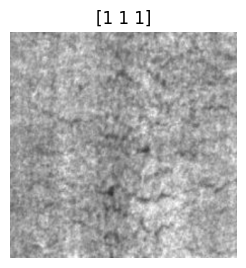

In [22]:
for images, labels in dataset.take(1):
    visualize_batch(images, labels)


In [23]:
import tensorflow as tf

raw_dataset = tf.data.TFRecordDataset('D:/content/tensorflow/training_demo/annotations/train.tfrecord')
for raw_record in raw_dataset.take(5):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)


features {
  feature {
    key: "image/width"
    value {
      int64_list {
        value: 640
      }
    }
  }
  feature {
    key: "image/source_id"
    value {
      bytes_list {
        value: "crazing_1.jpg"
      }
    }
  }
  feature {
    key: "image/object/view"
    value {
      bytes_list {
        value: "Unspecified"
      }
    }
  }
  feature {
    key: "image/object/truncated"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "image/object/difficult"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "image/object/class/text"
    value {
      bytes_list {
        value: "crazing"
      }
    }
  }
  feature {
    key: "image/object/class/label"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "image/object/bbox/ymin"
    value {
      float_list {
        value: 0.01
      }
    }
  }
  feature {
    key: "image/object/bbox/ymax"
    value {
      float_list

In [24]:
import tensorflow as tf

def read_tfrecord(serialized_example):
    feature_description = {
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    class_text = tf.sparse.to_dense(example['image/object/class/text'])
    return class_text

raw_dataset = tf.data.TFRecordDataset('D:/content/tensorflow/training_demo/annotations/train.tfrecord')
for raw_record in raw_dataset.take(5):
    class_names = read_tfrecord(raw_record)
    print(class_names.numpy())


[b'crazing']
[b'crazing' b'crazing']
[b'crazing' b'crazing' b'crazing' b'crazing']
[b'crazing']
[b'crazing' b'crazing']
